In [1]:
import pennylane as qml
from pennylane import numpy as np
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, execute, Aer, IBMQ
from qiskit.visualization import plot_histogram, plot_bloch_multivector
from qiskit.aqua.components.optimizers import COBYLA
import matplotlib.pyplot as plt

## Simple example - Optimize the circuit for creating a Bell state

In [2]:
#trivial solution
qr = QuantumRegister(2)
cr = ClassicalRegister(2)
qc = QuantumCircuit(qr, cr)
qc.h(0) # Put qubit a into state |+>
qc.cx(0,1) # CNOT with a as control and b as target
qc.measure(0,0)
qc.measure(1,1)
qc.draw()

┌───┐     ┌─┐   
q0_0: ┤ H ├──■──┤M├───
      └───┘┌─┴─┐└╥┘┌─┐
q0_1: ─────┤ X ├─╫─┤M├
           └───┘ ║ └╥┘
c0: 2/═══════════╩══╩═
                 0  1

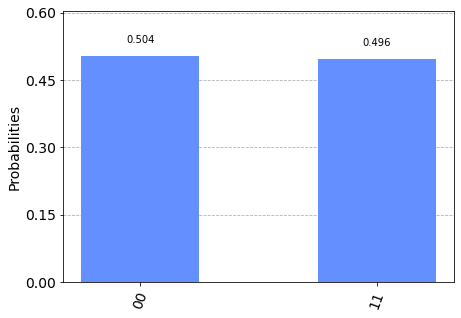

In [3]:
backend = Aer.get_backend('qasm_simulator')
counts = execute(qc, backend, shots=1024).result().get_counts()
plot_histogram(counts)

In [4]:
dev = qml.device('default.qubit', wires = 2)
qml.QubitStateVector(np.array([]), wires = 1)

QubitStateVector(tensor([], dtype=float64, requires_grad=True), wires=[1])

In [5]:
@qml.qnode(dev)
def circuit(params):
    A = np.array([[ 0.5, 0.5],
           [ 0.5,  0.5]])
    qml.U3(params[0], params[1], params[2], wires = 0)
    
    return qml.expval(qml.Hermitian(A, wires = 0))

In [6]:
params = [np.pi*0.5, 0, 0.3]
a = circuit(params)
a

0.9999999999999996

In [7]:
def cost(x):
    
    return (1.0 - circuit(x))

In [8]:
init_params = np.array([0.7, 0, 0.3])
cost(init_params)

0.17789115638115482

In [9]:
opt = qml.GradientDescentOptimizer(stepsize = 0.4)

steps = 100

params = init_params

In [10]:
for i in range(steps):
    
    params = opt.step(cost, params)
    
print(params)

[1.57079633 0.         0.3       ]


In [11]:
cost(params)

4.440892098500626e-16

## Generating a proper random quantum state and its probability vector

Explain some things here
$|\psi\rangle \rightarrow |\psi\rangle \langle \psi |$

$|v| = \sqrt{\langle v| v \rangle} = \sqrt{v^{\dagger}v}$

In [12]:
def norm(complex_vector: np.array) -> float:
    """Returns the norm of a complex vector.
    
    Args:
       complex_vector (np.arrray of shape (dim,)):
           complex vector with an arbitrary dimension.
           
       
    Returns:
        norm (float): norm or magnitude of the complex vector.
            
    """
    
    #define the norm of a complex vector here
    norm = np.sqrt(sum([np.square(np.absolute(complex_vector[i])) for i in range(complex_vector.shape[0])]))
    
    return norm

def random_quantum_state(dim: int) -> np.array:
    """Creates a normalized random complex vector of a defined
    dimension.
    
    Args:
        dim (int): integer number specifying the dimension
            of the vector that we want to generate.
            
    Returns:
        (np.array): normalized complex vector of the given
            dimension.
    """
    #generate an unnormalized complex vector of dimension = dim
    Z = np.random.random(dim) + np.random.random(dim)*1j
    
    #normalize the complex vector Z
    Z /= norm(Z)
    
    return Z

def get_probabilities(complex_vector: np.array) -> np.array:
    """Get the probabilities associated to a quantum state.
    This is a vector in which each element is the square of
    the magnitude of respective complex number in that element.
    
    Args:
        complex_vector (np.array):
        
    Retuns:
        (np.array): 
    """
    
    if 1.0 - norm(complex_vector) > 0.001:
        print("Alert! The quantum state apparently is not normalized.")
        
    else:
        return np.square(np.absolute(complex_vector))

In [13]:
#two qubits -> a complex vector of dimension 4
n_qubits = 3
dim = 2**(n_qubits)
psi = random_quantum_state(dim)

In [14]:
get_probabilities(psi)

tensor([0.30681749, 0.12824695, 0.01372895, 0.22550634, 0.06946752,
        0.00092427, 0.14340705, 0.11190143], requires_grad=True)

In [15]:
n_qubits = 1
dim = 2**(n_qubits)
psi = random_quantum_state(dim)

In [16]:
target_distr = get_probabilities(psi)
target_distr

tensor([0.54529265, 0.45470735], requires_grad=True)

In [17]:
def get_var_form(params):
    qr = QuantumRegister(1, name="q")
    cr = ClassicalRegister(1, name='c')
    qc = QuantumCircuit(qr, cr)
    qc.u3(params[0], params[1], params[2], qr[0])
    qc.measure(qr, cr[0])
    return qc

## Building the variational quantum circuit

In [18]:
def build_variational_circuit(number_layers: int, params: np.array) -> QuantumCircuit:
    #how many parameters will have given the number_layers
    n_parameters = 8*number_layers
    
    if params.shape[0] != n_parameters:
        print(f"Alert! You gave {params.shape[0]} parameters for a circuit of {n_parameters} parameters.")
        
    else:
        #create the circuit
        qr = QuantumRegister(4, name="q")
        cr = ClassicalRegister(4, name="c")
        qc = QuantumCircuit(qr, cr)

        #number of parameters per layer
        n_parameters_per_layer = 8
        for i in range(number_layers):
            start = i*n_parameters_per_layer
            end = (i+1)*n_parameters_per_layer 
            layer(qc, params[start:end])
            
        return qc
    
def layer(qc: QuantumCircuit, params: np.array) -> None:
    
    n_parameters = 8
    
    if params.shape[0] != n_parameters:
        print(f"Alert! You gave {params.shape[0]} parameters for a layer of {n_parameters} parameters.")
        
    else:
        odd_block(qc, params[:int(n_parameters/2)])
        even_block(qc, params[int(n_parameters/2):])
        qc.barrier()
        
#qiskit  odd block
def odd_block(qc: QuantumCircuit, params: np.array) -> None:
    
    n_parameters = 4
    
    if params.shape[0] != n_parameters:
        print(f"Alert! You gave {params.shape[0]} parameters for a block of {n_parameters} parameters.")
        
    else:
    
        for i in range(n_parameters):
            qc.rx(params[i], i)
        
#qiskit even block
def even_block(qc: QuantumCircuit, params: np.array) -> None:
    
    n_parameters = 4
    
    if params.shape[0] != n_parameters:
        print(f"Alert! You gave {params.shape[0]} parameters for a block of {n_parameters} parameters.")
        
    else:
    
        for i in range(n_parameters):
            qc.rz(params[i], i)

        tuples = [(i,j) for i in range(n_parameters) for j in range(n_parameters) if i < j]

        for tup in tuples:
            qc.cz(tup[0], tup[1])

In [19]:
n_parameters_per_layer = 8
n_layers = 2
params = np.random.rand(n_layers*n_parameters_per_layer)*2*np.pi
qc = build_variational_circuit(n_layers, params)

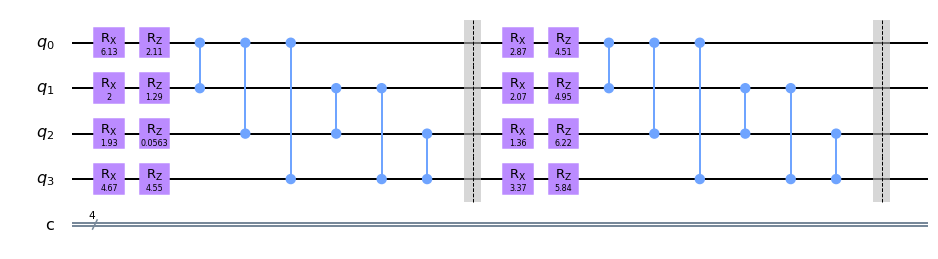

In [20]:
qc.draw(output='mpl')

## Optimization

In [21]:
backend = Aer.get_backend('statevector_simulator')

job = execute(qc, backend)

result = job.result()

outputstate = result.get_statevector(qc, decimals=3)
print(outputstate)

[-0.0104471 +0.01912094j  0.07751424+0.11995109j -0.0194285 +0.06650325j
  0.0090159 +0.34100617j -0.04016965-0.0509175j  -0.27087874-0.39196232j
  0.01314418+0.07267064j -0.22615956-0.30252759j -0.03281817+0.04225872j
 -0.30658613+0.40307637j  0.04726271-0.00196376j -0.18986578+0.12934964j
  0.0011948 +0.00054889j -0.2864493 +0.07407649j -0.05564645+0.02065949j
 -0.21759506+0.16081491j]


In [22]:
def norm_vector_difference(params):
    
    qc = build_variational_circuit(n_layers, params)
    
    job = execute(qc, backend)
    
    result = job.result()

    outputstate = result.get_statevector(qc, decimals=3)
    
    diff = outputstate - target_vector
    
    
    return norm(diff)

def get_probability_distribution(counts):
    output_distr = [v / NUM_SHOTS for v in counts.values()]
    if len(output_distr) == 1:
        output_distr.append(0)
    output_distr = np.asarray(output_distr)
    
    return output_distr

def probability_difference(params):
    # Obtain a quantum circuit instance from the paramters
    qc = build_variational_circuit(n_layers, params)
    # Measure all qubits
    qc.measure_all()
    # Execute the quantum circuit to obtain the probability distribution associated with the current parameters
    result = execute(qc, backend, shots=NUM_SHOTS).result()
    # Obtain the counts for each measured state, and convert those counts into a probability vector
    output_distr = get_probability_distribution(result.get_counts(qc))
    # Calculate the cost as the distance between the output distribution and the target distribution
    cost = sum([np.absolute(output_distr[i] - target_distr[i]) for i in range(output_distr.shape[0])])
    return cost

In [23]:
n_qubits = 4
dim = n_qubits**2
target_vector = random_quantum_state(dim)
target_distr = get_probabilities(target_vector)
target_distr.shape

(16,)

In [24]:
# Initialize the COBYLA optimizer
optimizer = COBYLA(maxiter=500, tol=0.0001)

# Create the initial parameters (noting that our single qubit variational form has 3 parameters)
cost_list = []
for n_layers in range(1,11):
    n_parameters_per_layer = 8
    params = np.random.rand(n_layers*n_parameters_per_layer)*2*np.pi
    ret = optimizer.optimize(num_vars=n_layers*n_parameters_per_layer, objective_function=norm_vector_difference, 
                             initial_point=params)

    # Obtain the output distribution using the final parameters
    qc = build_variational_circuit(n_layers, ret[0])
    final_vector = execute(qc, backend).result().get_statevector(qc, decimals = 3)
    
    #save cost function values
    cost_list.append(ret[1])
    
    print("Number of layers:", n_layers)
    print("Target Vector:", target_vector)
    print("Obtained Vector:", final_vector)
    print("cost:", ret[1])
    print("Parameters Found:", ret[0])
    print('')

Number of layers: 1
Target Vector: [0.27880179+0.10388648j 0.29230849+0.11945961j 0.29458621+0.22297268j
 0.15905184+0.30283767j 0.24250811+0.18320201j 0.16318235+0.07394478j
 0.24750895+0.04959239j 0.23499773+0.03795151j 0.02986665+0.12103475j
 0.09494707+0.03792004j 0.2503946 +0.28971586j 0.1226632 +0.07480293j
 0.17080896+0.16056022j 0.08629606+0.08270936j 0.06201211+0.10159041j
 0.16247803+0.10161386j]
Obtained Vector: [-0.07345284+0.00000000e+00j  0.02026406+5.53529546e-02j
  0.57207236+1.69004770e-01j  0.03046299+4.77729878e-01j
  0.02021883+2.51725947e-02j -0.01339175+2.21811832e-02j
  0.09955158+2.42572296e-01j  0.15533469-1.41941035e-01j
  0.02522236+3.97821991e-02j -0.02302096+2.99822416e-02j
  0.10490586+3.67868618e-01j  0.24827898-1.80542498e-01j
 -0.00669075+1.95943654e-02j  0.01661185-3.63615722e-04j
  0.09719343-1.37212204e-01j  0.13021462+3.53896131e-02j]
cost: 0.8954299908156356
Parameters Found: [ 7.63570688  2.89655267  0.82828157  1.14044537  5.93225064  4.99964373


Number of layers: 8
Target Vector: [0.27880179+0.10388648j 0.29230849+0.11945961j 0.29458621+0.22297268j
 0.15905184+0.30283767j 0.24250811+0.18320201j 0.16318235+0.07394478j
 0.24750895+0.04959239j 0.23499773+0.03795151j 0.02986665+0.12103475j
 0.09494707+0.03792004j 0.2503946 +0.28971586j 0.1226632 +0.07480293j
 0.17080896+0.16056022j 0.08629606+0.08270936j 0.06201211+0.10159041j
 0.16247803+0.10161386j]
Obtained Vector: [0.24683839+0.05817267j 0.32300768+0.13023542j 0.37200281+0.18088613j
 0.20402056+0.3012285j  0.18049553+0.2099295j  0.17902046+0.102676j
 0.1810375 +0.02640105j 0.18925962+0.00562024j 0.02355628+0.0374181j
 0.13216131+0.02866458j 0.20970815+0.32711248j 0.12339386+0.06285173j
 0.26174767+0.04608652j 0.04214828-0.01288245j 0.11246626+0.08097392j
 0.15885078+0.12224374j]
cost: 0.27433350886102503
Parameters Found: [ 4.90266865  1.07638453  4.55372236  3.12011169  1.34771191  7.10248282
  1.88884409  3.21980828  3.66508472  5.72194207  2.30775807  4.636878
  1.70724753 

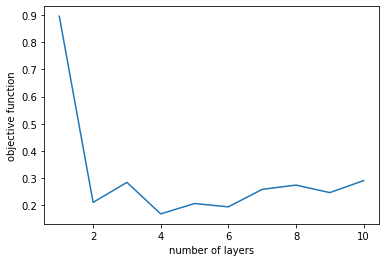

In [25]:
n_layers = range(1,11)
plt.plot(n_layers, cost_list)
plt.xlabel("number of layers")
plt.ylabel("objective function")
plt.show()

In [26]:
backend = Aer.get_backend("qasm_simulator")
NUM_SHOTS = 10000

# Initialize the COBYLA optimizer
optimizer = COBYLA(maxiter=500, tol=0.0001)

# Create the initial parameters (noting that our single qubit variational form has 3 parameters)
n_parameters_per_layer = 8
cost_list = []
for n_layers in range(1,11):
    params = np.random.rand(n_layers*n_parameters_per_layer)*2*np.pi
    ret = optimizer.optimize(num_vars=n_layers*n_parameters_per_layer, objective_function=probability_difference, 
                             initial_point=params)

    # Obtain the output distribution using the final parameters
    qc = build_variational_circuit(n_layers, ret[0])
    qc.measure_all()
    counts = execute(qc, backend, shots=NUM_SHOTS).result().get_counts(qc)
    output_distr = get_probability_distribution(counts)
    
    cost_list.append(ret[1])
    
    print("Number of layers:", n_layers)
    print("Target Distribution:", target_distr)
    print("Obtained Distribution:", output_distr)
    print("Output Error (Manhattan Distance):", ret[1])
    print("Parameters Found:", ret[0])
    print('')

Number of layers: 1
Target Distribution: [0.08852284 0.09971485 0.13649785 0.11700814 0.09237316 0.03209631
 0.06372009 0.05666425 0.01554143 0.01045288 0.14663274 0.02064174
 0.05495529 0.01428785 0.01416611 0.03672449]
Obtained Distribution: [0.0335 0.1634 0.0232 0.0936 0.0783 0.3476 0.0447 0.2157]
Output Error (Manhattan Distance): 0.7610466639939542
Parameters Found: [2.27255903 1.31715696 3.14824475 1.96262146 4.88131401 5.83732027
 1.30256766 4.66035564]

Number of layers: 2
Target Distribution: [0.08852284 0.09971485 0.13649785 0.11700814 0.09237316 0.03209631
 0.06372009 0.05666425 0.01554143 0.01045288 0.14663274 0.02064174
 0.05495529 0.01428785 0.01416611 0.03672449]
Obtained Distribution: [0.0909 0.084  0.1469 0.0187 0.11   0.061  0.0735 0.0764 0.0226 0.0088
 0.1568 0.0415 0.0569 0.0116 0.0323 0.0081]
Output Error (Manhattan Distance): 0.2854007151299476
Parameters Found: [3.68238839 7.59261611 1.36857423 5.40958384 2.59432416 5.8060926
 2.75266708 0.94673922 2.03900015 4.6

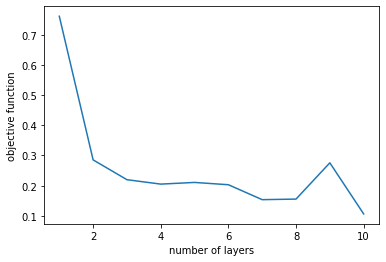

In [27]:
n_layers = range(1,11)
plt.plot(n_layers, cost_list)
plt.xlabel("number of layers")
plt.ylabel("objective function")
plt.show()

In [28]:
# Obtain the output distribution using the final parameters
n_layers = 2
params = np.random.rand(n_layers*n_parameters_per_layer)*2*np.pi
qc = build_variational_circuit(n_layers, params)
qc.measure_all()
counts = execute(qc, backend, shots=NUM_SHOTS).result().get_counts(qc)
output_distr = get_probability_distribution(counts)
output_distr.shape

(16,)

In [29]:
density_matrix = psi @ np.transpose(np.conjugate(psi))